# Universidad de Buenos Aires
# Aprendizaje Profundo - TP2
# Cohorte 20 - 3er bimestre 2025


Este segundo TP se debe entregar hasta las **23hs del domingo 17 de agosto (hora de Argentina)**. La resolución del TP es **individual**. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citadas incluyendo el correspondiente link o página de libro.

ESTE TP2 EQUIVALE AL 40% DE SU NOTA FINAL.

El formato de entrega debe ser un link a un notebook de google colab. Permitir acceso a gvilcamiza.ext@fi.uba.ar y **habilitar los comentarios, para poder darles el feedback**. Si no lo hacen así no se podrá dar el feedback respectivo por cada pregunta.

El envío **se realizará en el siguiente link de google forms: [link](https://forms.gle/wgKVpFhX6F6Nfkf46)**. Tanto los resultados, gráficas, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

**NO SE VALIDARÁN ENVÍOS POR CORREO, EL MÉTODO DE ENTREGA ES SOLO POR EL FORMS.**

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para este TP2.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-TP2-Co20.ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código, los gráficos y las explicaciones deben quedar guardados y visualizables en el correspondiente notebook.
- Prestar atención a las consignas, responder las preguntas cuando corresponda.
- Solo se revisarán los trabajos que hayan sido enviados por el forms.

# **CLASIFICADOR DE EMOCIONES**

El objetivo de este trabajo es construir una red neuronal convolucional (CNN) utilizando Pytorch, capaz de clasificar emociones humanas a partir de imágenes faciales. El clasificador deberá identificar una de las 7 emociones básicas: alegría, tristeza, enojo, miedo, sorpresa, disgusto y seriedad. El dataset se encuentra en este link: https://drive.google.com/file/d/1pGsz3NFVHOfDpFG3jvpuM4NtpDCv757Z/view?usp=sharing

## 1. Preprocesamiento de Datos (2 puntos)

Antes de entrenar el modelo, se debe analizar qué tipo de preprocesamiento se debe aplicar a las imágenes. Para esto, se puede considerar uno o más aspectos como:

- Tamaño
- Relación de aspecto
- Color o escala de grises
- Cambio de dimensionalidad
- Normalización
- Balanceo de datos
- Data augmentation
- etc.

Sean criteriosos y elijan solo las técnicas que consideren pertinentes para este caso de uso en específico.

Recomendación: usar `torchvision.transforms` para facilitar el preprocesamiento.



In [51]:
import os
import supervision as sv
import cv2
import pandas as pd
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch
import torchinfo
import torchvision.transforms as T
from tqdm import tqdm

Exploring folder: dataset_emociones/train/seriedad
Exploring folder: dataset_emociones/train/sorpresa
Exploring folder: dataset_emociones/train/disgusto
Exploring folder: dataset_emociones/train/tristeza
Exploring folder: dataset_emociones/train/miedo
Exploring folder: dataset_emociones/train/enojo
Exploring folder: dataset_emociones/train/alegria


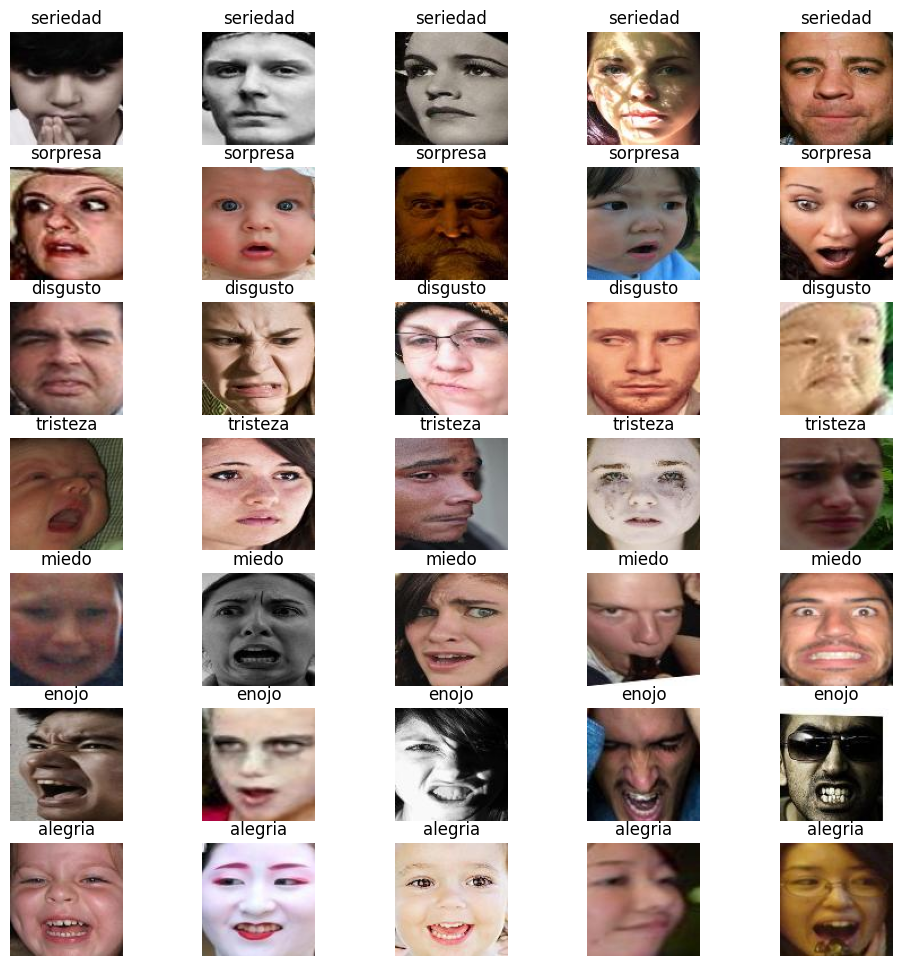

In [6]:
# Analisis exploratorio, imprimimos un par de imagenes por cada clase

DATA_PATH = 'dataset_emociones/train'

num_samples_to_show = 5
titles = list()
images = list()

for folder_name in os.listdir(DATA_PATH):
    folder_path = os.path.join(DATA_PATH, folder_name)
    print(f"Exploring folder: {folder_path}")
    if os.path.isdir(folder_path):
        for img_file in os.listdir(folder_path)[:num_samples_to_show]:
            img_path = os.path.join(folder_path, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                titles.append(folder_name)
    
sv.plot_images_grid(images=images, titles=titles, grid_size=(len(set(titles)), num_samples_to_show))

Reestructuro el dataset para que sea mas manejable. Voy a crear un archivo csv con las etiquetas y paths
correspondientes a cada imagen, tanto para test como para train.

In [13]:
def is_image(file_name: str) -> bool:
    return file_name.lower().endswith(
        ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff'))    

def generate_image_csv(
    data_dir: str,
) -> pd.DataFrame:
    """
    Generate a CSV file with image paths and class labels.
    
    Parameters
    ----------
    data_dir:str
        Path to the root directory containing class-named folders of images.
    """
    data = []

    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            for image_name in os.listdir(class_path):
                if is_image(file_name=image_name):
                    data.append([os.path.join(class_path, image_name), class_name])
    return pd.DataFrame(data)

dataset_val = 'dataset_emociones/validation'
dataset_train = 'dataset_emociones/train'

df_train = generate_image_csv(data_dir=dataset_train)
df_val = generate_image_csv(data_dir=dataset_val)

df_train.to_csv('train.csv', index=False, header=False)
df_val.to_csv('validation.csv', index=False, header=False)

A partir de aca trabajamos con el dataset en el nuevo formato

7 classes in train dataset
7 classes in val dataset
Classes: ['seriedad' 'sorpresa' 'disgusto' 'tristeza' 'miedo' 'enojo' 'alegria']
Train dataset: 12271 images
Validation dataset: 3068 images
val / train ratio: 0.25 

Distribucion de clases en train 
-------------------------------
1
alegria     4772
seriedad    2524
tristeza    1982
sorpresa    1290
disgusto     717
enojo        705
miedo        281
Name: count, dtype: int64


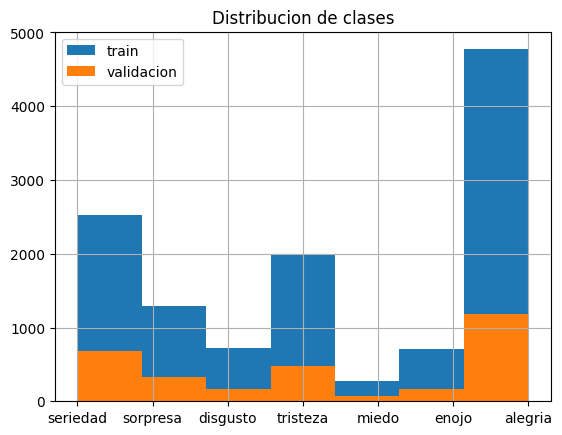

In [36]:
df_train = pd.read_csv('train.csv', header=None)
df_val = pd.read_csv('validation.csv', header=None)

print(f"{df_train[1].nunique()} classes in train dataset")
print(f"{df_val[1].nunique()} classes in val dataset")
print(f"Classes: {df_train[1].unique()}")
print(f"Train dataset: {len(df_train)} images")
print(f"Validation dataset: {len(df_val)} images")
print(f"val / train ratio: {len(df_val) / len(df_train):.2f} \n")

print("Distribucion de clases en train \n-------------------------------")
print(df_train[1].value_counts())

df_train[1].hist(bins=df_train[1].nunique())
df_val[1].hist(bins=df_val[1].nunique())
plt.title("Distribucion de clases")
plt.legend(["train", "validacion"])

Vemos que el dataset contiene imagenes de 100x100 pixeles. Con un fuerte desbalance para la clase "alegria", la
cual duplica en cantidad a la 2da clase mayoritaria (seriedad) y supera en un orden de magnitud a la minoritaria (miedo).
La distribucion de clases de validacion y train es proporcional entre ambos conjuntos, incluso se respeta el desbalance entre las clases mecionado arriba.


In [47]:
# Dataset y dataloader

class ImgClassificationDataset(Dataset):

    IMG_CLASS_COL = 1

    def __init__(self, dataset_csv:str, transform=None):
        """
        Parameters
        ----------
        dataset_csv:str
            Path to a csv file contaning image name and class labels
        """
        super().__init__()

        self.transform = transform
        self._dataset_df = pd.read_csv(dataset_csv, header=None)
        self.labels = list(set(self._dataset_df[self.IMG_CLASS_COL]))
        self.label2id = {label:i for i, label in enumerate(self.labels)}
        self.id2label = {i:label for i, label in enumerate(self.labels)}

    def __getitem__(self, index):
        # store as attributes for further usage
        self.image_path, self.class_name = self._dataset_df.loc[index]
        image_bgr = (cv2.imread(self.image_path) / 255.0).astype('float32')
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        if self.transform:
            image_rgb = self.transform(image_rgb)
        return image_rgb, self.label2id[self.class_name]

    def __len__(self):
        return len(self._dataset_df)

transforms = T.Compose([
     T.ToTensor(),
    T.RandomVerticalFlip(),
    T.Resize((224, 224)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = T.Compose([
    T.ToTensor(),
    # T.Resize((224, 224)),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImgClassificationDataset(
    dataset_csv='train.csv', transform=transforms)
val_dataset = ImgClassificationDataset(
    dataset_csv='validation.csv', transform=val_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32)

## 2. Construcción y entrenamiento del Modelo CNN (3.5 puntos)

- Construir una red neuronal convolucional desde cero, sin usar modelos pre-entrenados.
- Analizar correctamente qué funciones de activación se deben usar en cada etapa de la red, el learning rate a utilizar, la función de costo y el optimizador.
- Cosas como el número de capas, neuronas, tanaño de kernel, entre otros, queda a criterio de ustedes, pero deben estar justificadas.

In [35]:
class ResBlock(nn.Module):

    def __init__(self, in_channels, intermediate_channels, stride):
        
        """
        Creates a residual block that adds the input feature maps to the output
        feature maps of the block.
        
        Note:
          1. Addition of feature maps occur at just before the final ReLU with the input feature maps
          2. if input size is different from output, select projected mapping or else identity mapping.
        Args:
            in_channels (int) : input channels to the Bottleneck
            intermediate_channels (int) : number of channels to 3x3 conv 
            expansion (int) : factor by which the input #channels are increased
            stride (int) : stride applied in the 3x3 conv. 2 for first Bottleneck of the block and 1 for remaining

        Attributes:
            Layer consisting of conv->batchnorm->relu
        """

        super(ResBlock, self).__init__()

        self.in_channels = in_channels
        self.intermediate_channels = intermediate_channels
        
        # i.e. if dim(x) == dim(F) => Identity function
        if self.in_channels == self.intermediate_channels:
            self.identity = True
        else:
            self.identity = False
            projection_layer = []
            projection_layer.append(nn.Conv2d(in_channels=self.in_channels, out_channels=self.intermediate_channels, kernel_size=1, stride=stride, padding=0, bias=False ))
            projection_layer.append(nn.BatchNorm2d(self.intermediate_channels))
            # Only conv->BN and no ReLU
            # projection_layer.append(nn.ReLU())
            self.projection = nn.Sequential(*projection_layer)

        self.relu = nn.ReLU()

        self.conv1_3x3 = nn.Conv2d(
            in_channels=self.in_channels, out_channels=self.intermediate_channels, kernel_size=3, stride=stride, padding=1, bias=False )
        self.batchnorm1 = nn.BatchNorm2d(self.intermediate_channels)
            
        self.conv2_3x3 = nn.Conv2d(in_channels=self.intermediate_channels, out_channels=self.intermediate_channels, kernel_size=3, stride=1, padding=1, bias=False )
        self.batchnorm2 = nn.BatchNorm2d(self.intermediate_channels)

    def forward(self, x):
        
        in_x = x # save to be summed at the output

        x = self.relu(self.batchnorm1(self.conv1_3x3(x)))
        x = self.batchnorm2(self.conv2_3x3(x))
        # identity or projected mapping
        if self.identity:
            x += in_x
        else:
            x += self.projection(in_x)
        x = self.relu(x)
        
        return x


class ResNet18(nn.Module):

    def __init__(
        self, 
        num_classes: int, 
        in_channels: int = 3
    ):
        """
        Creates the ResNet architecture based on the provided variant. 18/34/50/101 etc.
        Based on the input parameters, define the channels list, repeatition list along with expansion factor(4) and stride(3/1)
        using _make_blocks method, create a sequence of multiple Bottlenecks
        Average Pool at the end before the FC layer 

        Args:
            resnet_variant (list) : eg. [[64,128,256,512],[3,4,6,3],4,True]
            in_channels (int) : image channels (3)
            num_classes (int) : output #classes 

        Attributes:
            Layer consisting of conv->batchnorm->relu

        """
        super(ResNet18, self).__init__()
        self.channels_list = [64, 128, 256, 512] # resnet filters per layer
        self.repetition_list = [2, 2, 2, 2] # block repetition per layer

        # First conv block at the network input. This block never repeats.
        self.conv1 = nn.Conv2d(
            in_channels=in_channels, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Create residual blocks 
        self.block1 = self._make_blocks(64, self.channels_list[0], self.repetition_list[0], stride=1 )
        self.block2 = self._make_blocks(self.channels_list[0], self.channels_list[1], self.repetition_list[1], stride=2)
        self.block3 = self._make_blocks(self.channels_list[1], self.channels_list[2], self.repetition_list[2], stride=2)
        self.block4 = self._make_blocks(self.channels_list[2], self.channels_list[3], self.repetition_list[3], stride=2)

        # Output block with classification head
        self.average_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(self.channels_list[3], num_classes)

    def forward(self,x):

        x = self.relu(self.batchnorm1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        x = self.average_pool(x)

        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        
        return x

    def _make_blocks(
        self,
        in_channels,
        intermediate_channels, 
        num_repeat, 
        stride):
        
        """
        Args:
            in_channels : #channels of the Bottleneck input
            intermediate_channels : #channels of the 3x3 in the Bottleneck
            num_repeat : #Bottlenecks in the block
            stride : stride to be used in the first Bottleneck conv 3x3

        Attributes:
            Sequence of Bottleneck layers

        """
        layers = [] 

        layers.append(ResBlock(in_channels, intermediate_channels, stride=stride))
        for _ in range(1, num_repeat):
            layers.append(ResBlock(intermediate_channels, intermediate_channels, stride=1))

        return nn.Sequential(*layers)

In [41]:
model = ResNet18(num_classes=len(train_dataset.label2id))
torchinfo.summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet18                                 [1, 7]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,472
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─ResBlock: 2-1                     [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

In [53]:
EPOCHS = 50
LR = 0.001

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model.to('cuda' if torch.cuda.is_available() else 'cpu')
loss_avg = list()

for epoch in range(EPOCHS):
    model.train()
    loss_avg.append(0)
    batch_count = 0
    for images, labels in tqdm(train_loader):

        batch_count += 1
        images, labels = images.to('cuda'), labels.to('cuda')

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        loss_avg[-1] += loss.item()
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    loss_avg[-1] /= batch_count

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {loss_avg[-1]:.4f}")


100%|██████████| 384/384 [00:21<00:00, 17.57it/s]


Epoch [1/50], Loss: 1.1783


100%|██████████| 384/384 [00:21<00:00, 18.05it/s]


Epoch [2/50], Loss: 1.0352


100%|██████████| 384/384 [00:21<00:00, 18.10it/s]


Epoch [3/50], Loss: 0.9448


100%|██████████| 384/384 [00:20<00:00, 18.36it/s]


Epoch [4/50], Loss: 0.8762


100%|██████████| 384/384 [00:21<00:00, 18.09it/s]


Epoch [5/50], Loss: 0.8043


100%|██████████| 384/384 [00:20<00:00, 18.36it/s]


Epoch [6/50], Loss: 0.7497


100%|██████████| 384/384 [00:21<00:00, 17.90it/s]


Epoch [7/50], Loss: 0.6882


100%|██████████| 384/384 [00:22<00:00, 17.07it/s]


Epoch [8/50], Loss: 0.6411


100%|██████████| 384/384 [00:20<00:00, 18.54it/s]


Epoch [9/50], Loss: 0.5799


100%|██████████| 384/384 [00:20<00:00, 18.54it/s]


Epoch [10/50], Loss: 0.5184


100%|██████████| 384/384 [00:21<00:00, 17.83it/s]


Epoch [11/50], Loss: 0.4837


100%|██████████| 384/384 [00:21<00:00, 17.69it/s]


Epoch [12/50], Loss: 0.4234


100%|██████████| 384/384 [00:21<00:00, 18.12it/s]


Epoch [13/50], Loss: 0.3681


100%|██████████| 384/384 [00:21<00:00, 17.63it/s]


Epoch [14/50], Loss: 0.3016


100%|██████████| 384/384 [00:21<00:00, 18.22it/s]


Epoch [15/50], Loss: 0.2836


100%|██████████| 384/384 [00:20<00:00, 18.33it/s]


Epoch [16/50], Loss: 0.2189


100%|██████████| 384/384 [00:20<00:00, 18.54it/s]


Epoch [17/50], Loss: 0.1984


100%|██████████| 384/384 [00:20<00:00, 18.52it/s]


Epoch [18/50], Loss: 0.1771


100%|██████████| 384/384 [00:21<00:00, 17.90it/s]


Epoch [19/50], Loss: 0.1444


100%|██████████| 384/384 [00:21<00:00, 18.18it/s]


Epoch [20/50], Loss: 0.1491


100%|██████████| 384/384 [00:20<00:00, 18.59it/s]


Epoch [21/50], Loss: 0.1160


100%|██████████| 384/384 [00:21<00:00, 17.99it/s]


Epoch [22/50], Loss: 0.0997


100%|██████████| 384/384 [00:21<00:00, 17.81it/s]


Epoch [23/50], Loss: 0.0947


100%|██████████| 384/384 [00:20<00:00, 18.48it/s]


Epoch [24/50], Loss: 0.0937


100%|██████████| 384/384 [00:20<00:00, 18.33it/s]


Epoch [25/50], Loss: 0.0757


100%|██████████| 384/384 [00:21<00:00, 18.12it/s]


Epoch [26/50], Loss: 0.0929


100%|██████████| 384/384 [00:21<00:00, 17.92it/s]


Epoch [27/50], Loss: 0.0809


100%|██████████| 384/384 [00:20<00:00, 18.39it/s]


Epoch [28/50], Loss: 0.0695


100%|██████████| 384/384 [00:20<00:00, 18.30it/s]


Epoch [29/50], Loss: 0.0614


100%|██████████| 384/384 [00:20<00:00, 18.47it/s]


Epoch [30/50], Loss: 0.0648


100%|██████████| 384/384 [00:20<00:00, 18.36it/s]


Epoch [31/50], Loss: 0.0752


100%|██████████| 384/384 [00:20<00:00, 18.47it/s]


Epoch [32/50], Loss: 0.0647


100%|██████████| 384/384 [00:20<00:00, 18.51it/s]


Epoch [33/50], Loss: 0.0562


100%|██████████| 384/384 [00:21<00:00, 17.63it/s]


Epoch [34/50], Loss: 0.0479


100%|██████████| 384/384 [00:21<00:00, 18.20it/s]


Epoch [35/50], Loss: 0.0558


100%|██████████| 384/384 [00:21<00:00, 18.02it/s]


Epoch [36/50], Loss: 0.0583


100%|██████████| 384/384 [00:21<00:00, 17.93it/s]


Epoch [37/50], Loss: 0.0545


100%|██████████| 384/384 [00:20<00:00, 18.93it/s]


Epoch [38/50], Loss: 0.0453


100%|██████████| 384/384 [00:22<00:00, 17.45it/s]


Epoch [39/50], Loss: 0.0596


100%|██████████| 384/384 [00:21<00:00, 18.13it/s]


Epoch [40/50], Loss: 0.0417


100%|██████████| 384/384 [00:21<00:00, 18.25it/s]


Epoch [41/50], Loss: 0.0400


100%|██████████| 384/384 [00:20<00:00, 18.44it/s]


Epoch [42/50], Loss: 0.0355


100%|██████████| 384/384 [00:20<00:00, 18.44it/s]


Epoch [43/50], Loss: 0.0391


100%|██████████| 384/384 [00:21<00:00, 18.00it/s]


Epoch [44/50], Loss: 0.0427


100%|██████████| 384/384 [00:21<00:00, 17.93it/s]


Epoch [45/50], Loss: 0.0475


100%|██████████| 384/384 [00:21<00:00, 18.14it/s]


Epoch [46/50], Loss: 0.0391


100%|██████████| 384/384 [00:21<00:00, 18.20it/s]


Epoch [47/50], Loss: 0.0383


100%|██████████| 384/384 [00:21<00:00, 18.10it/s]


Epoch [48/50], Loss: 0.0385


100%|██████████| 384/384 [00:20<00:00, 18.61it/s]


Epoch [49/50], Loss: 0.0314


100%|██████████| 384/384 [00:22<00:00, 17.24it/s]

Epoch [50/50], Loss: 0.0474


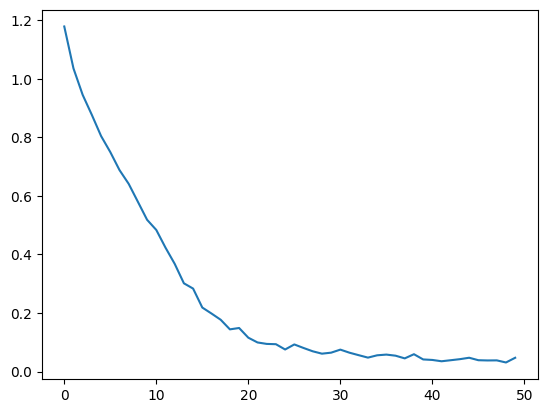

In [55]:
from matplotlib import pyplot as plt

plt.plot(range(EPOCHS), loss_avg)

## 3. Evaluación del Modelo (2.5 puntos)

El modelo entrenado debe ser evaluado utilizando las siguientes métricas:

- **Accuracy**:
  - Reportar el valor final en el conjunto de validación.
  - Incluir una gráfica de evolución por época para entrenamiento y validación.

- **F1 Score**:
  - Reportar el valor final en el conjunto de validación.
  - Incluir una gráfica de evolución por época para entrenamiento y validación.

- **Costo (Loss)**:
  - Mostrar una gráfica de evolución del costo por época para entrenamiento y validación.

- **Classification report**
  - Mostrar la precisión, recall y F1 score por cada clase usando `classification_report`

- **Matriz de confusión**:
  - Mostrar la matriz de confusión absoluta (valores enteros).
  - Mostrar la matriz de confusión normalizada (valores entre 0 y 1 por fila).

Se recomienda utilizar `scikit-learn` para calcular métricas como accuracy, F1 score, el Classification report y las matrices de confusión. Las visualizaciones pueden realizarse con `matplotlib` o `seaborn`, separando claramente los datos de entrenamiento y validación en las gráficas.


 ## 4. Prueba de Imágenes Nuevas (1 punto)
Subir al menos 5 imágenes personales de cualquier relación de aspecto (pueden usar fotos del rostro de ustedes, rostros de personas generadas por IA o imágenes stock de internet), que no formen parte del dataset de entrenamiento ni de validación.

- Cada imagen debe representar una emoción distinta.

- Aplicar el mismo pre-procesamiento que se usó para el dataset durante el entrenamiento del modelo.

- Pasar las imágenes por el modelo entrenado y mostrar:

  - La imagen original
  - La imagen pre-procesada (mismas transformaciones del entrenamiento)
  - El score asignado a cada clase
  - La clase ganadora inferida por el modelo

- Redactar conclusiones preliminares

 ## 5. Prueba de Imágenes Nuevas con Pre-procesamiento Adicional (1 punto)
Las 5 imágenes del punto 4, ahora serán pasadas y recortadas por un algoritmo de detección de rostros. Usen el siguiente código para realizar un pre-procesamiento inicial de la imagen y ya luego aplican el pre-procesamiento que usaron al momento de entrenar el modelo.

- Pasar las imágenes por el modelo entrenado y mostrar:
  - La imagen original
  - La imagen recortada por el algoritmo
  - La imagen pre-procesada (mismas transformaciones del entrenamiento)
  - El score asignado a cada clase
  - La clase ganadora inferida por el modelo

- Comparar los resultados con el punto 4 y redactar conclusiones finales.

NOTA: Pueden adaptar el código según crean conveniente para obtener mejores resultados.

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

image_path = ""

image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=6)

image_with_box = image.copy()
for (x, y, w, h) in faces:
    cv2.rectangle(image_with_box, (x, y), (x + w, y + h), (0, 255, 0), 2)

cropped_face_rgb = None
if len(faces) > 0:
    (x, y, w, h) = faces[0]
    center_x, center_y = x + w // 2, y + h // 2
    side = max(w, h)
    half_side = side // 2

    x1 = max(center_x - half_side, 0)
    y1 = max(center_y - half_side, 0)
    x2 = min(center_x + half_side, image.shape[1])
    y2 = min(center_y + half_side, image.shape[0])

    cropped_face = image[y1:y2, x1:x2]
    cropped_face_rgb = cv2.cvtColor(cropped_face, cv2.COLOR_BGR2RGB)

image_with_box_rgb = cv2.cvtColor(image_with_box, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image_with_box_rgb)
ax[0].set_title("Detección")
ax[0].axis('off')

if cropped_face_rgb is not None:
    ax[1].imshow(cropped_face_rgb)
    ax[1].set_title("Rostro recortado (relación aspecto 1:1)")
    ax[1].axis('off')
else:
    ax[1].text(0.5, 0.5, 'No se detectó rostro', horizontalalignment='center', verticalalignment='center')
    ax[1].axis('off')

plt.tight_layout()
plt.show()
